In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_Y_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4187    2022-08-31
4188    2022-09-30
4189    2022-10-31
4190    2022-11-30
4191    2022-12-31
Name: ship_date, Length: 4192, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: mon_1, Length: 4192, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1420 entries, (114, Timestamp('2009-11-30 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 117 entries, year to year_trend
dtypes: float64(14), int32(3), int64(78), object(10), uint8(12)
memory usage: 1.1+ MB


(117, 167, 18)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


## RX

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10        -0.4140     0.1402    -2.9535     0.0032     -0.6890     -0.1390
elapsed_m9         -0.2457     0.1236    -1.9870     0.0471     -0.4883     -0.0031
elapsed_m8         -0.1858     0.1099    -1.6904     0.0912     -0.4015      0.0298
elapsed_m7         -0.4222     0.1318    -3.2042     0.0014     -0.6808     -0.1637
elapsed_m6          0.0030     0.0873     0.0343     0.9726     -0.1684      0.1743
elapsed_m5         -0.1451     0.0560    -2.5914     0.0097     -0.2549     -0.0352
elapsed_m4         -0.0252     0.0662    -0.3813     0.7030     -0.1550      0.1046
elapsed_m3         -0.1303     0.0550    -2.3666     0.0181     -0.2383     -0.0223
elapsed_m2         -0.0773     0.0661    -1.1682     0.2429     -0.2070     

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rx_dom   R-squared:                        0.1362
Estimator:                   PanelOLS   R-squared (Between):              0.0418
No. Observations:                1420   R-squared (Within):               0.0595
Date:                Sun, Sep 17 2023   R-squared (Overall):              0.0433
Time:                        08:37:43   Log-likelihood                   -368.76
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.0596
Entities:                          18   P-value                           0.0000
Avg Obs:                       78.889   Distribution:                 F(27,1209)
Min Obs:                       47.000                                           
Max Obs:                       167.00   F-statistic (robust):         -4.918e+14
                            

C:\Users\hakos\AppData\Local\Temp\ipykernel_21788\2276844448.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mon_1, mon_2, mon_3, mon_4, mon_5, mon_6, mon_7, mon_8, mon_9, mon_10, mon_11, mon_12

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


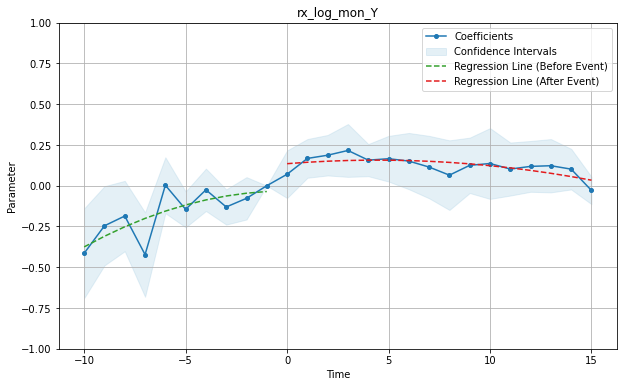

In [8]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_Y",title="rx_log_mon_Y",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10         0.2296     0.5027     0.4567     0.6479     -0.7567      1.2159
elapsed_m9          0.0729     0.4707     0.1549     0.8769     -0.8505      0.9963
elapsed_m8         -0.5563     0.4897    -1.1360     0.2562     -1.5172      0.4045
elapsed_m7          0.4102     0.4844     0.8467     0.3973     -0.5402      1.3606
elapsed_m6         -0.8935     0.3671    -2.4340     0.0151     -1.6138     -0.1733
elapsed_m5         -0.8420     0.2719    -3.0973     0.0020     -1.3754     -0.3087
elapsed_m4         -0.2742     0.2549    -1.0758     0.2822     -0.7744      0.2259
elapsed_m3         -0.4155     0.3800    -1.0933     0.2745     -1.1610      0.3301
elapsed_m2         -0.4764     0.4374    -1.0891     0.2763     -1.3345     

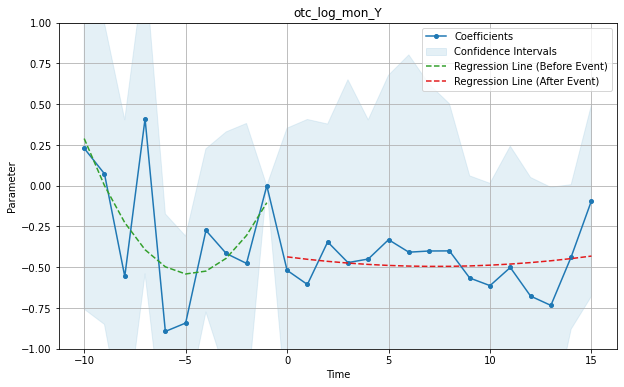

In [9]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_Y",title="otc_log_mon_Y",ylim=(-1,1),plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)